In [1]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
import squidpy as sq
import sccellfie
import scanpy as sc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os

In [3]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling')

### Read Preprocessed Annotated Data 

In [4]:
adata = sc.read(filename=parent_dir / 'data/h5ad/mean_cell_gene_removed_normalized.h5ad')
adata

AnnData object with n_obs × n_vars = 1167018 × 193
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [5]:
adata.var_names = adata.var["gene"].astype(str)
adata.var_names_make_unique()

In [6]:
counts = adata.obs.groupby(["Subject_ID","Treatment_Status"]).size().unstack()
counts

Treatment_Status  Treated  Untreated
Subject_ID                          
78410A1                 0      34762
89397               64653          0
92604               65599          0
95278A2                 0       8067
114262                725          0
118223A                 0      47666
120136              34549          0
120139                  0      64305
120140                  0      41077
120149              11768          0
120153              75872          0
120161              64464        245
468115             132108          0
1180097B                0      39510
1182412B            28026          0
1182623B                0      70370
1185092B             3527          0
1192325B                0      64716
1204245B                0      29284
1207356B                0      48900
1209622B                0      92288
1216278B                0     104719
1228762B                0      25447
1258057B                0      14371

In [7]:
patient_id = '120136' # 120136: treated or 1180097B: untreated

adata_one_patient = adata[adata.obs['Subject_ID'] == patient_id]
adata_one_patient

View of AnnData object with n_obs × n_vars = 34549 × 193
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

### Compute Fluxomic (reaction/metabolic tasks) Data from Spatial Transcriptomic Data using scCellFie

In [8]:
results = sccellfie.run_sccellfie_pipeline(adata_one_patient,
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='nCount_Nanostring',
                                           process_by_group=False,
                                           groupby=None, # 'Treatment_Status' or None
                                           neighbors_key='neighbors',
                                           n_neighbors=10,
                                           batch_key='sample',
                                           threshold_key='sccellfie_threshold',
                                           smooth_cells=True,
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=True,
                                           save_folder=None, # 'result or None',
                                           save_filename=None, # 'sccellfie_results or None'
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (34549, 11)
Number of GPRs: 37
Shape of tasks by genes: (77, 11)
Shape of reactions by genes: (37, 11)
Shape of tasks by reactions: (77, 37)

---- scCellFie Step: Smoothing gene expression ----

---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----

---- scCellFie Step: Computing metabolic task activity ----
Removed 7 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Cell - Cell Communication Results for one patient

In [9]:
patient_adata = results["adata"]

In [30]:
tasks = patient_adata.metabolic_tasks.var_names
print("Number of metabolic tasks:", len(tasks))

Number of metabolic tasks: 70


In [33]:
# Task-Info.csv or 
task_info_df = pd.read_csv(base_dir / 'Task_Info_with_CRC_binary.csv')
task_info_df

Task  \
0                     (R)-3-Hydroxybutanoate synthesis   
1             3'-Phospho-5'-adenylyl sulfate synthesis   
2                             AMP salvage from adenine   
3    ATP generation from glucose (hypoxic condition...   
4    ATP regeneration from glucose (normoxic condit...   
..                                                 ...   
213      Synthesis of androstenedione from cholesterol   
214  Synthesis of estradiol-17beta (E2) from andros...   
215     Synthesis of estrone (E1) from androstenedione   
216         Synthesis of progesterone from cholesterol   
217     Synthesis of testosterone from androstenedione   

                       System                Subsystem  Upregulated_in_CRC  
0    CARBOHYDRATES METABOLISM              KETOGENESIS                   0  
1       NUCLEOTIDE METABOLISM                 COFACTOR                   0  
2       NUCLEOTIDE METABOLISM                  SALVAGE                   0  
3           ENERGY METABOLISM           ATP GENERATION                   1  
4           ENERGY METABOLISM           ATP GENERATION                   0  
..                        ...                      ...                 ...  
213       HORMONES METABOLISM      ANDROGEN METABOLISM                   0  
214       HORMONES METABOLISM      ESTROGEN METABOLISM                   0  
215       HORMONES METABOLISM      ESTROGEN METABOLISM                   0  
216       HORMONES METABOLISM  PROGESTERONE METABOLISM                   0  
217       HORMONES METABOLISM      ANDROGEN METABOLISM                   0  

[218 rows x 4 columns]

In [38]:
# Biological View
crc_important_task = task_info_df[task_info_df['Upregulated_in_CRC'] == 1].reset_index(drop=True)
crc_important_task

Task  \
0   ATP generation from glucose (hypoxic condition...   
1                                   Alanine synthesis   
2                              Arachidonate synthesis   
3                                  Arginine synthesis   
4                                Asparagine synthesis   
5                                 Aspartate synthesis   
6                                  Ceramide synthesis   
7        Deoxyadenosine triphosphate synthesis (dATP)   
8         Deoxycytidine triphosphate synthesis (dCTP)   
9        Deoxyguanosine triphosphate synthesis (dGTP)   
10       Deoxythymidine triphosphate synthesis (dTTP)   
11                      Glucose to lactate conversion   
12                              Glutamine degradation   
13              Glutaminolysis (glutamine to lactate)   
14             Guanosine triphosphate synthesis (GTP)   
15                Hydroxymethylglutaryl-CoA synthesis   
16              Inosine monophosphate synthesis (IMP)   
17                                Palmitate synthesis   
18                     Phosphatidyl-choline synthesis   
19                Phosphatidyl-ethanolamine synthesis   
20                                  Proline synthesis   
21                   Recognition of misfolded protein   
22     Retro-translocation & substrate ubiquitination   
23                                 Serine degradation   
24                                   Serine synthesis   
25              Sialylation (addition of sialic acid)   
26                            Sphingomyelin synthesis   
27          Synthesis of L-kynurenine from tryptophan   
28  Synthesis of galactosyl glucosyl ceramide (lin...   
29                      Synthesis of glucocerebroside   
30                Synthesis of kynate from tryptophan   
31                           Synthesis of malonyl-coa   
32                         Synthesis of palmitoyl-CoA   
33                    Synthesis of ribose-5-phosphate   
34         Synthesis of thromboxane from arachidonate   
35                             Tryptophan degradation   
36               Uridine triphosphate synthesis (UTP)   
37                                  Vesicle secretion   

                      System                          Subsystem  \
0          ENERGY METABOLISM                     ATP GENERATION   
1     AMINO ACIDS METABOLISM                 ALANINE METABOLISM   
2          LIPIDS METABOLISM              FATTY ACID METABOLISM   
3     AMINO ACIDS METABOLISM                ARGININE METABOLISM   
4     AMINO ACIDS METABOLISM              ASPARAGINE METABOLISM   
5     AMINO ACIDS METABOLISM               ASPARTATE METABOLISM   
6          LIPIDS METABOLISM            SPHINGOLIPID METABOLISM   
7      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
8      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
9      NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
10     NUCLEOTIDE METABOLISM         DEOXYNUCLEOTIDES SYNTHESIS   
11  CARBOHYDRATES METABOLISM                PYRUVATE METABOLISM   
12    AMINO ACIDS METABOLISM               GLUTAMINE METABOLISM   
13    AMINO ACIDS METABOLISM               GLUTAMINE METABOLISM   
14     NUCLEOTIDE METABOLISM  IMP SYNTHESIS / PURINE METABOLISM   
15         LIPIDS METABOLISM             CHOLESTEROL METABOLISM   
16     NUCLEOTIDE METABOLISM  IMP SYNTHESIS / PURINE METABOLISM   
17         LIPIDS METABOLISM              FATTY ACID METABOLISM   
18         LIPIDS METABOLISM     GLYCEROPHOSPHOLIPID METABOLISM   
19         LIPIDS METABOLISM     GLYCEROPHOSPHOLIPID METABOLISM   
20    AMINO ACIDS METABOLISM                 PROLINE METABOLISM   
21              Proteostasis                               ERAD   
22              Proteostasis                               ERAD   
23    AMINO ACIDS METABOLISM                  SERINE METABOLISM   
24    AMINO ACIDS METABOLISM                  SERINE METABOLISM   
25   Processing in the Golgi        N-glycan processing (Golgi)   
26         LIPID

In [ ]:
patient_task_df = pd.DataFrame(tasks.tolist(),columns=["Task"])
patient_task_info = pd.merge(patient_task_df, crc_important_task, left_on="Task", right_on="Task", how="left")
patient_task_info.dropna(inplace=True)
patient_task_info.reset_index(inplace=True, drop=True)
patient_task_info

Task  \
0   ATP generation from glucose (hypoxic condition...   
1                                   Alanine synthesis   
2                              Arachidonate synthesis   
3                                  Arginine synthesis   
4                                Asparagine synthesis   
5                                 Aspartate synthesis   
6                                  Ceramide synthesis   
7                       Glucose to lactate conversion   
8                               Glutamine degradation   
9               Glutaminolysis (glutamine to lactate)   
10                Hydroxymethylglutaryl-CoA synthesis   
11                                Palmitate synthesis   
12                     Phosphatidyl-choline synthesis   
13                Phosphatidyl-ethanolamine synthesis   
14                                  Proline synthesis   
15                            Sphingomyelin synthesis   
16  Synthesis of galactosyl glucosyl ceramide (lin...   
17                      Synthesis of glucocerebroside   
18                           Synthesis of malonyl-coa   
19                         Synthesis of palmitoyl-CoA   
20                             Tryptophan degradation   
21                                  Vesicle secretion   

                      System                       Subsystem  \
0          ENERGY METABOLISM                  ATP GENERATION   
1     AMINO ACIDS METABOLISM              ALANINE METABOLISM   
2          LIPIDS METABOLISM           FATTY ACID METABOLISM   
3     AMINO ACIDS METABOLISM             ARGININE METABOLISM   
4     AMINO ACIDS METABOLISM           ASPARAGINE METABOLISM   
5     AMINO ACIDS METABOLISM            ASPARTATE METABOLISM   
6          LIPIDS METABOLISM         SPHINGOLIPID METABOLISM   
7   CARBOHYDRATES METABOLISM             PYRUVATE METABOLISM   
8     AMINO ACIDS METABOLISM            GLUTAMINE METABOLISM   
9     AMINO ACIDS METABOLISM            GLUTAMINE METABOLISM   
10         LIPIDS METABOLISM          CHOLESTEROL METABOLISM   
11         LIPIDS METABOLISM           FATTY ACID METABOLISM   
12         LIPIDS METABOLISM  GLYCEROPHOSPHOLIPID METABOLISM   
13         LIPIDS METABOLISM  GLYCEROPHOSPHOLIPID METABOLISM   
14    AMINO ACIDS METABOLISM              PROLINE METABOLISM   
15         LIPIDS METABOLISM         SPHINGOLIPID METABOLISM   
16         LIPIDS METABOLISM          GANGLIOSIDE METABOLISM   
17         LIPIDS METABOLISM          GANGLIOSIDE METABOLISM   
18         LIPIDS METABOLISM           FATTY ACID METABOLISM   
19         LIPIDS METABOLISM           FATTY ACID METABOLISM   
20    AMINO ACIDS METABOLISM           TRYPTOPHAN METABOLISM   
21       Vesicle trafficking               Vesicle secretion   

    Upregulated_in_CRC  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
5                  1.0  
6                  1.0  
7                  1.0  
8                  1.0  
9                  1.0  
10                 1.0  
11                 1.0  
12                 1.0  
13                 1.0  
14                 1.0  
15                 1.0  
16                 1.0  
17                 1.0  
18                 1.0  
19                 1.0  
20                 1.0  
21                 1.0

## Metabolic Task Analysis

### Correlation analysis (Spearman)

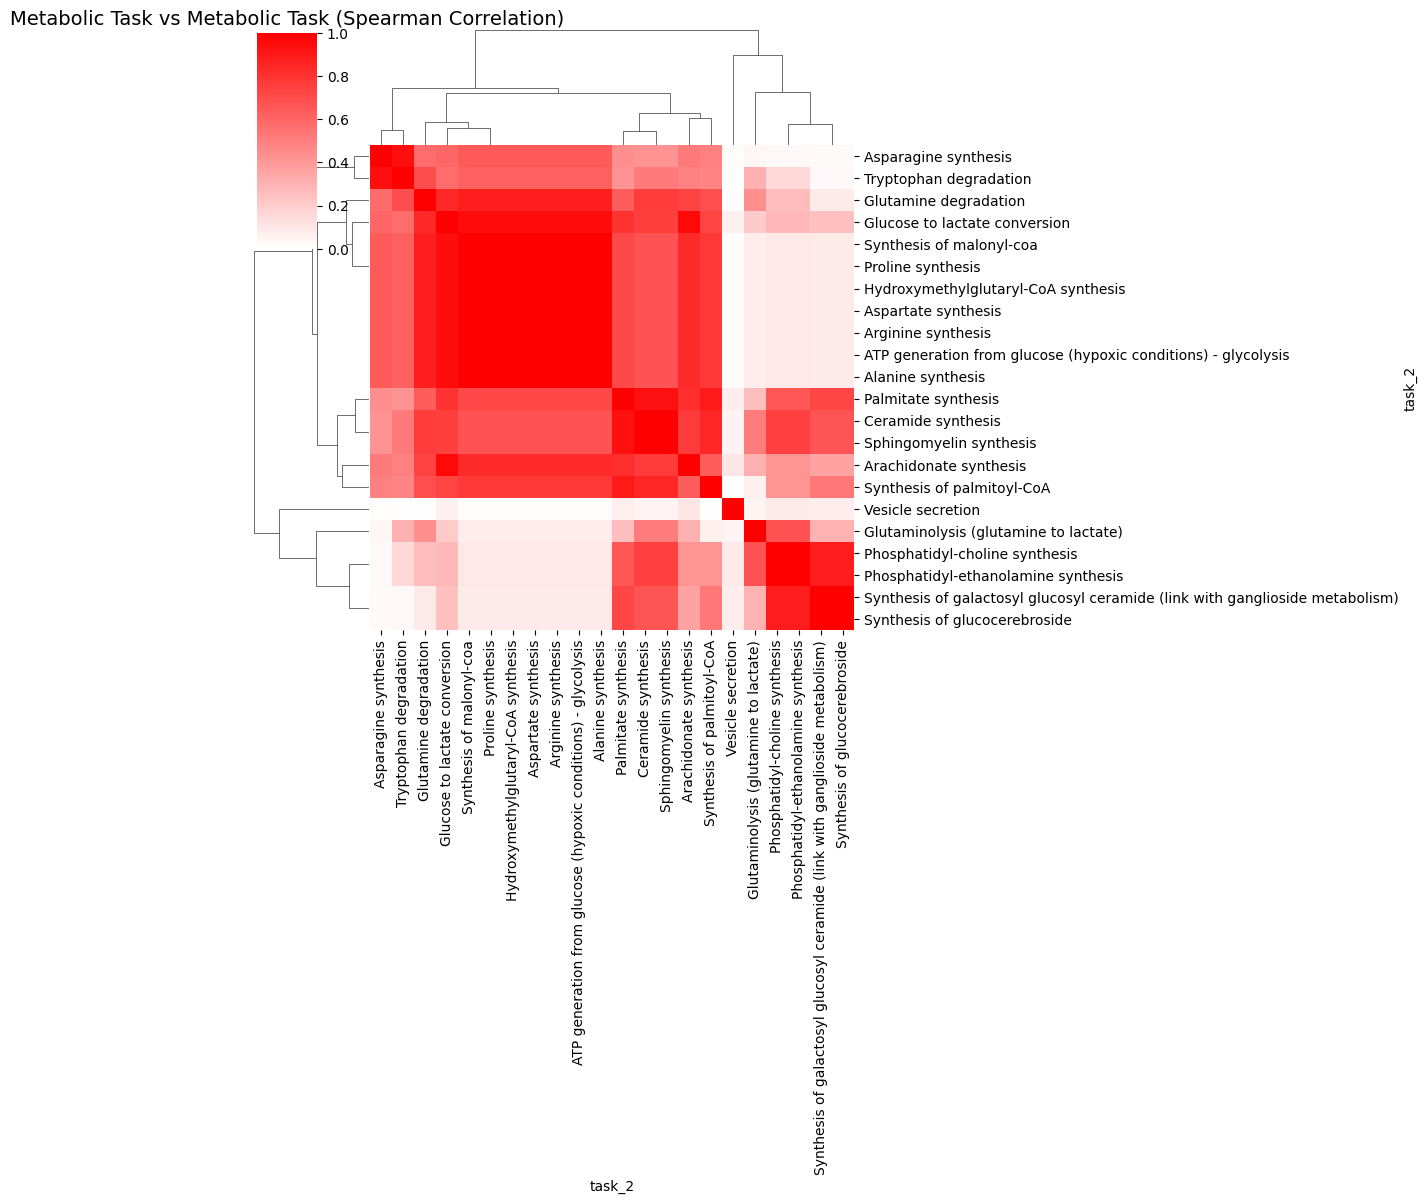

In [50]:
mt_df = patient_adata.metabolic_tasks.to_df()

corr_matrix = mt_df.corr(method='spearman')

corr_matrix_filtered = corr_matrix.loc[patient_task_info.Task.tolist(), patient_task_info.Task.tolist()]

pivot = corr_matrix_filtered.replace([np.inf, -np.inf], np.nan).fillna(0)

sns.clustermap(
    pivot,
    cmap='bwr',
    center=0,
    annot=False,
    figsize=(12, 12)
)

plt.title("Metabolic Task vs Metabolic Task (Spearman Correlation)", fontsize=14)
plt.show()


### Finding low, moderate, and high correlation pairs

In [51]:
# Set self-correlations (diagonal) to NaN so they are ignored
np.fill_diagonal(corr_matrix_filtered.values, np.nan)

# Convert correlation matrix to long format
corr_matrix_filtered.index.name = 'task_1'
corr_matrix_filtered.columns.name = 'task_2'
corr_long = corr_matrix_filtered.stack().reset_index(name='correlation')

# Remove duplicates (A–B same as B–A)
corr_long['pair'] = corr_long.apply(lambda x: tuple(sorted([x['task_1'], x['task_2']])), axis=1)
corr_long = corr_long.drop_duplicates(subset='pair').drop(columns='pair')

# Sort by correlation value
corr_sorted = corr_long.sort_values(by='correlation', ascending=True).reset_index(drop=True)

# Get lowest, mid, and highest
lowest = corr_sorted.iloc[0]
mid = corr_sorted.iloc[len(corr_sorted)//2]
highest = corr_sorted.iloc[-1]

print("🔻 Lowest correlated pair:")
print(f"  {lowest.task_1}  ↔  {lowest.task_2}  |  correlation = {lowest.correlation:.3f}")

print("\n⚖️  Mid-level correlated pair:")
print(f"  {mid.task_1}  ↔  {mid.task_2}  |  correlation = {mid.correlation:.3f}")

print("\n🔺 Highest correlated pair:")
print(f"  {highest.task_1}  ↔  {highest.task_2}  |  correlation = {highest.correlation:.3f}")


🔻 Lowest correlated pair:
  Synthesis of palmitoyl-CoA  ↔  Vesicle secretion  |  correlation = -0.001

⚖️  Mid-level correlated pair:
  Asparagine synthesis  ↔  Synthesis of malonyl-coa  |  correlation = 0.644

🔺 Highest correlated pair:
  Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism)  ↔  Synthesis of glucocerebroside  |  correlation = 1.000


### Visaulization of metabolic task value on spatial data

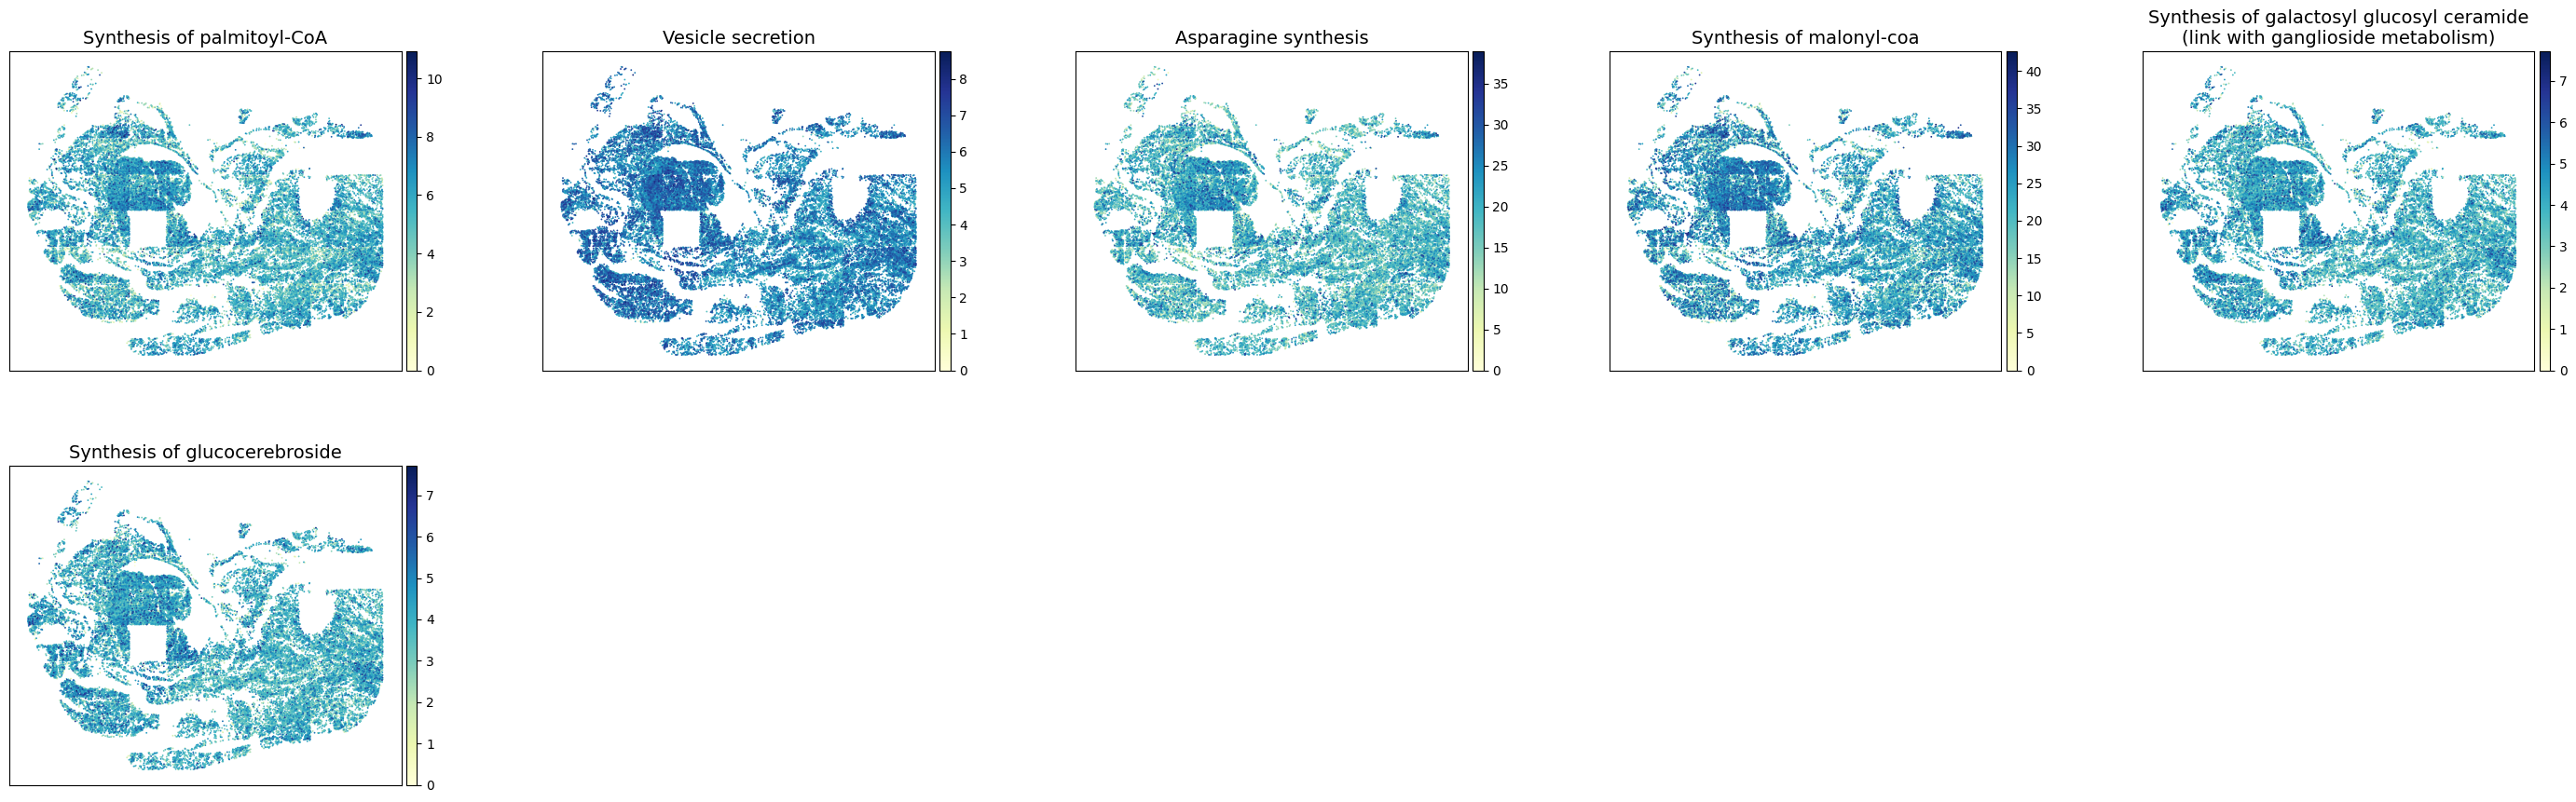

In [52]:
fig, axes = sccellfie.plotting.plot_spatial(patient_adata.metabolic_tasks,
                                            keys=[lowest.task_1, lowest.task_2, mid.task_1, mid.task_2,
                                                   highest.task_1, highest.task_2],
                                            spot_size=200, 
                                            cmap='YlGnBu',
                                            use_raw=False,
                                            ncols=5,
                                            hspace=0.3,
                                            vmin=0,
                                            save=patient_id
                                            )

## 🧠 Moran’s I — Spatial Autocorrelation Measure

---

### 📘 Definition  
**Moran’s I** quantifies how similar the values of a variable are among neighboring spatial locations.  
It measures the degree of **spatial autocorrelation** — that is, whether similar values tend to occur close to each other in space.

---

### 🔬 Purpose in Spatial Omics  
Helps identify whether **gene expression** or **metabolic task scores** form:  
- 🟢 **Spatial clusters** — similar values near each other (high positive correlation)  
- ⚪ **Random patterns** — no clear spatial structure (Moran’s I ≈ 0)  
- 🔴 **Alternating patterns** — neighboring cells with opposite values (negative correlation)

---

### 🧮 Mathematical Formula

$$
I = \frac{N}{W} \cdot 
    \frac{\sum_i \sum_j w_{ij} (x_i - \bar{x})(x_j - \bar{x})}
         {\sum_i (x_i - \bar{x})^2}
$$

**where:**

- $N$: number of spatial units (cells or spots)  
- $x_i$: value at cell *i*  
- $w_{ij}$: spatial weight (1 if neighbors, 0 if not)  
- $W = \sum_i \sum_j w_{ij}$: sum of all weights

---

### 📊 Interpretation

| Moran’s I value | Meaning | Spatial Pattern |
|-----------------|----------|-----------------|
| **≈ +1** | Strong positive autocorrelation | Clustered |
| **≈ 0** | No spatial structure | Random |
| **≈ −1** | Strong negative autocorrelation | Dispersed / Checkerboard |

---

### 🧬 Example in Spatial Transcriptomics  
Tasks or genes with high **Moran’s I** show **spatial organization**,  
e.g. glycolysis active only in a tumor region → Moran’s I = +0.7. Genes with Moran’s I ≈ 0 show random expression across tissue.

In [14]:
sq.gr.spatial_neighbors(patient_adata.metabolic_tasks, coord_type="generic", n_neighs=6)
sq.gr.spatial_autocorr(patient_adata.metabolic_tasks, mode="moran", genes=tasks)

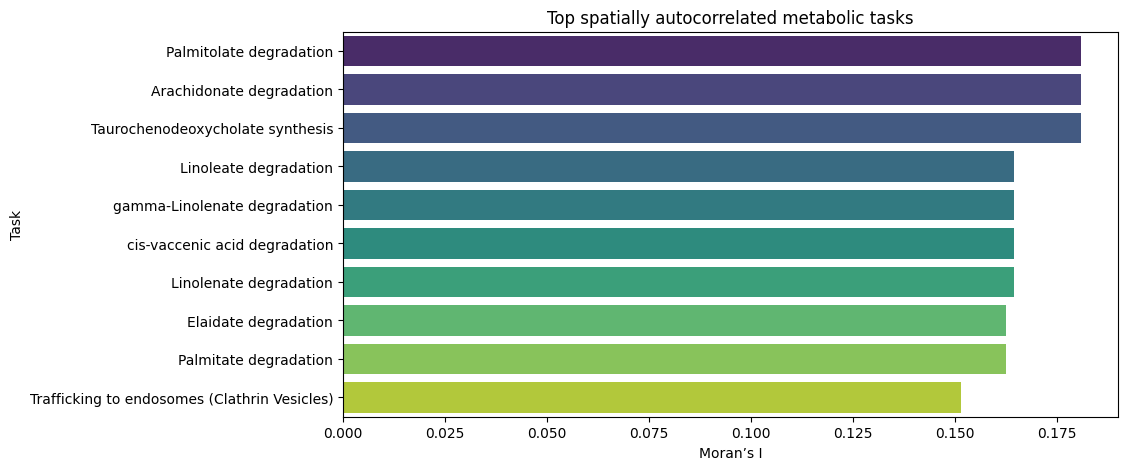

In [15]:
patient_moran = patient_adata.metabolic_tasks.uns["moranI"]
top_tasks = patient_moran.sort_values("I", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x="I", y=top_tasks.index, data=top_tasks, palette="viridis")
plt.title("Top spatially autocorrelated metabolic tasks")
plt.xlabel("Moran’s I")
plt.ylabel("Task")
plt.show()

In [16]:
# Get the min and max Moran's I values
max_task = patient_moran.loc[patient_moran['I'].idxmax()]
min_task = patient_moran.loc[patient_moran['I'].idxmin()]

print("🔺 Highest Moran’s I:")
print(f"  Task: {max_task.name}")
print(f"  I = {max_task['I']:.4f}")

print("\n🔻 Lowest Moran’s I:")
print(f"  Task: {min_task.name}")
print(f"  I = {min_task['I']:.4f}")

# Check if there are any negative values
neg_count = (patient_moran['I'] < 0).sum()
print(f"\n📉 Number of tasks with negative Moran’s I: {neg_count}")

if neg_count > 0:
    print("⚠️ Some tasks have negative Moran’s I → dispersed or alternating spatial patterns.")
else:
    print("✅ All Moran’s I values are positive → all tasks show clustered or random patterns.")


🔺 Highest Moran’s I:
  Task: Palmitolate degradation
  I = 0.1808

🔻 Lowest Moran’s I:
  Task: Cysteine degradation
  I = 0.0756

📉 Number of tasks with negative Moran’s I: 0
✅ All Moran’s I values are positive → all tasks show clustered or random patterns.


### Create KNN Neighbors graph

In [17]:
sccellfie.spatial.create_knn_network(patient_adata.metabolic_tasks, n_neighbors=10, spatial_key='spatial')

In [18]:
patient_adata_transfer = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=patient_adata,
    adata_source=patient_adata.metabolic_tasks,
    var_names=patient_adata.metabolic_tasks.var_names
)
patient_adata_transfer

AnnData object with n_obs × n_vars = 34549 × 81
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    uns: 'normalization', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts', 'smoothed_X', 'gene_scores'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

### Finding best Radius for Colocalization

In [19]:
r = sccellfie.spatial.compute_neighbor_distribution(
    patient_adata_transfer,
    radius_range=(100, 1500),  
    n_points=200,
    spatial_key='spatial'
)

(<Figure size 1500x800 with 4 Axes>, GridSpec(2, 3))

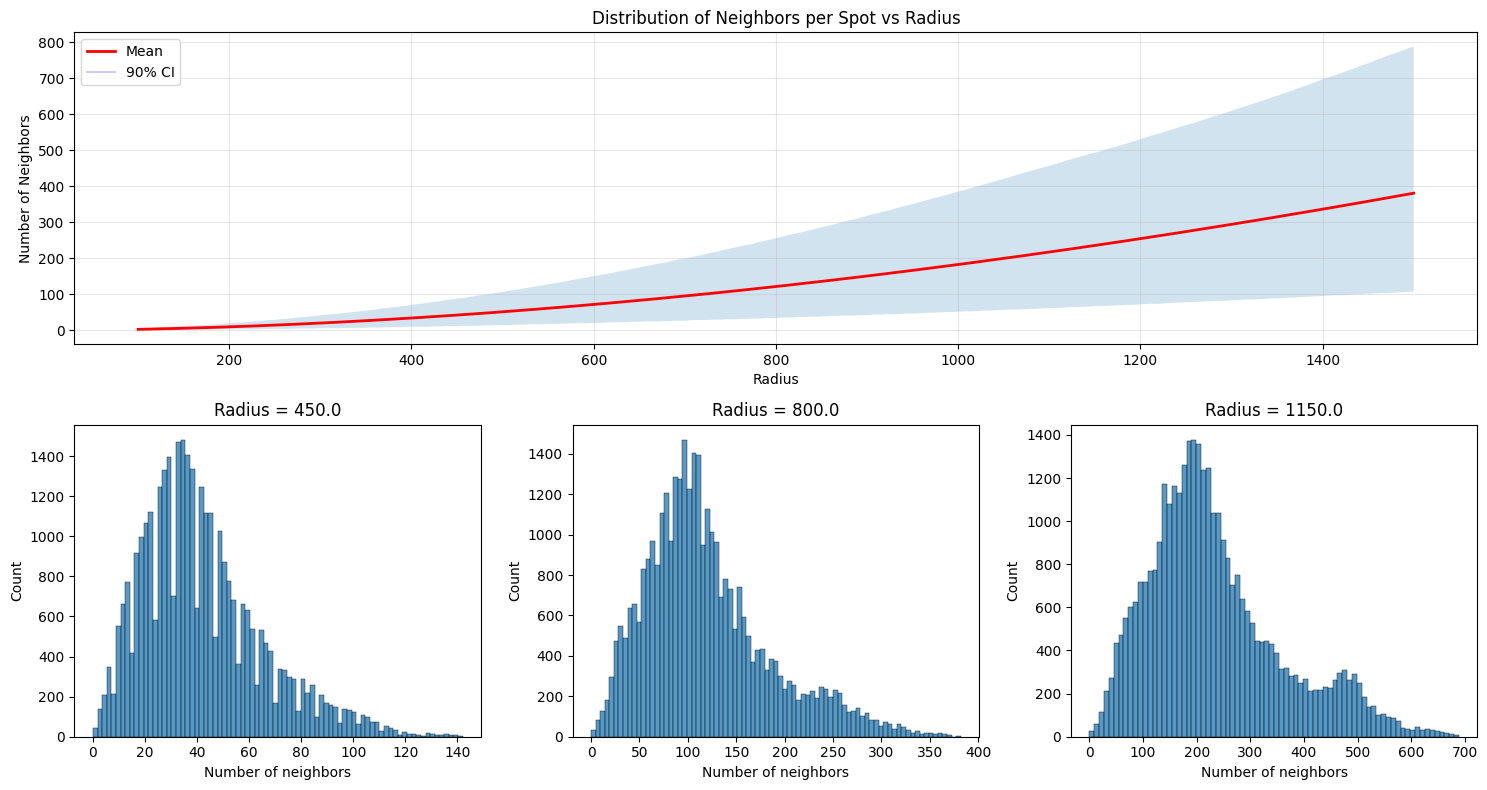

In [20]:
sccellfie.plotting.spatial.plot_neighbor_distribution(r)

## Colocalization analysis for selected pairs


🧬 Computing colocalization for Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion ...
✅ Done computing colocalization for Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion


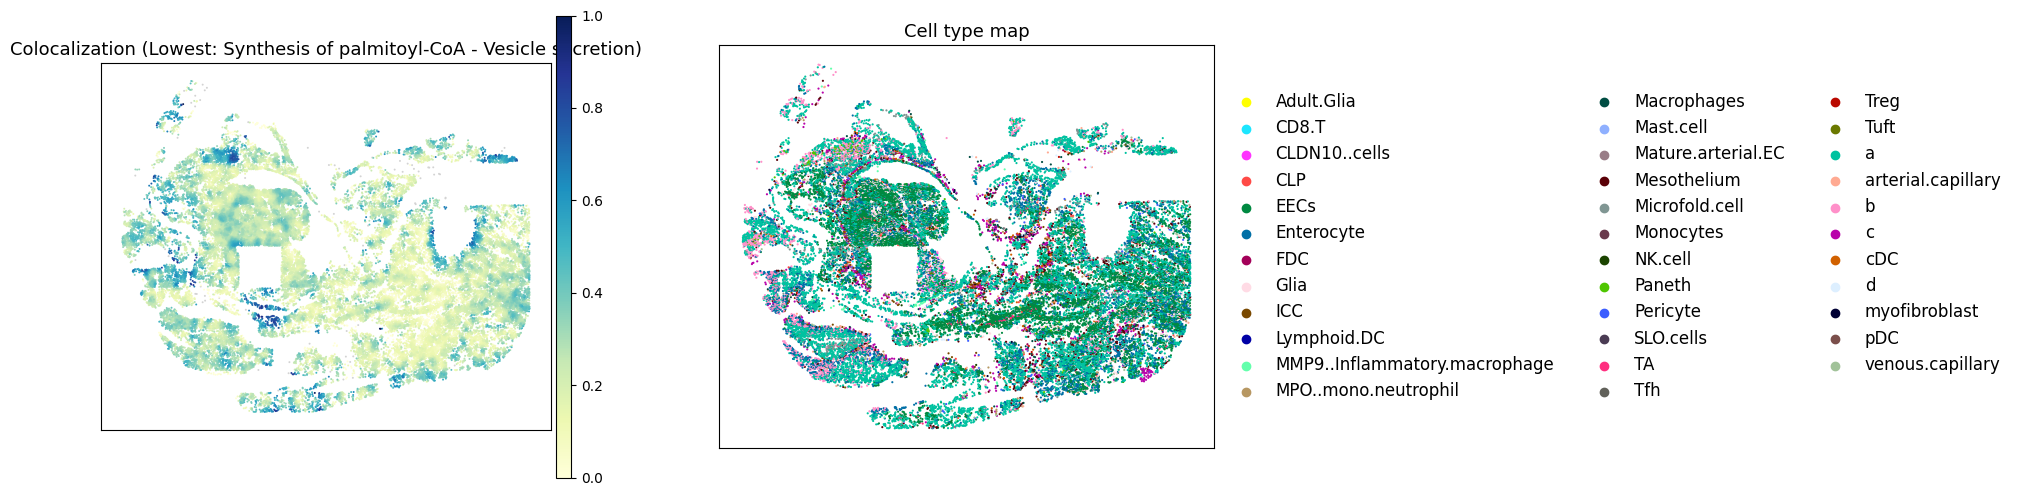

💾 Saved figure to: colocalization_pairs/Lowest_colocalization_Synthesis of palmitoyl-CoA_vs_Vesicle secretion.png

🧬 Computing colocalization for Mid: Asparagine synthesis - Synthesis of malonyl-coa ...
✅ Done computing colocalization for Mid: Asparagine synthesis - Synthesis of malonyl-coa


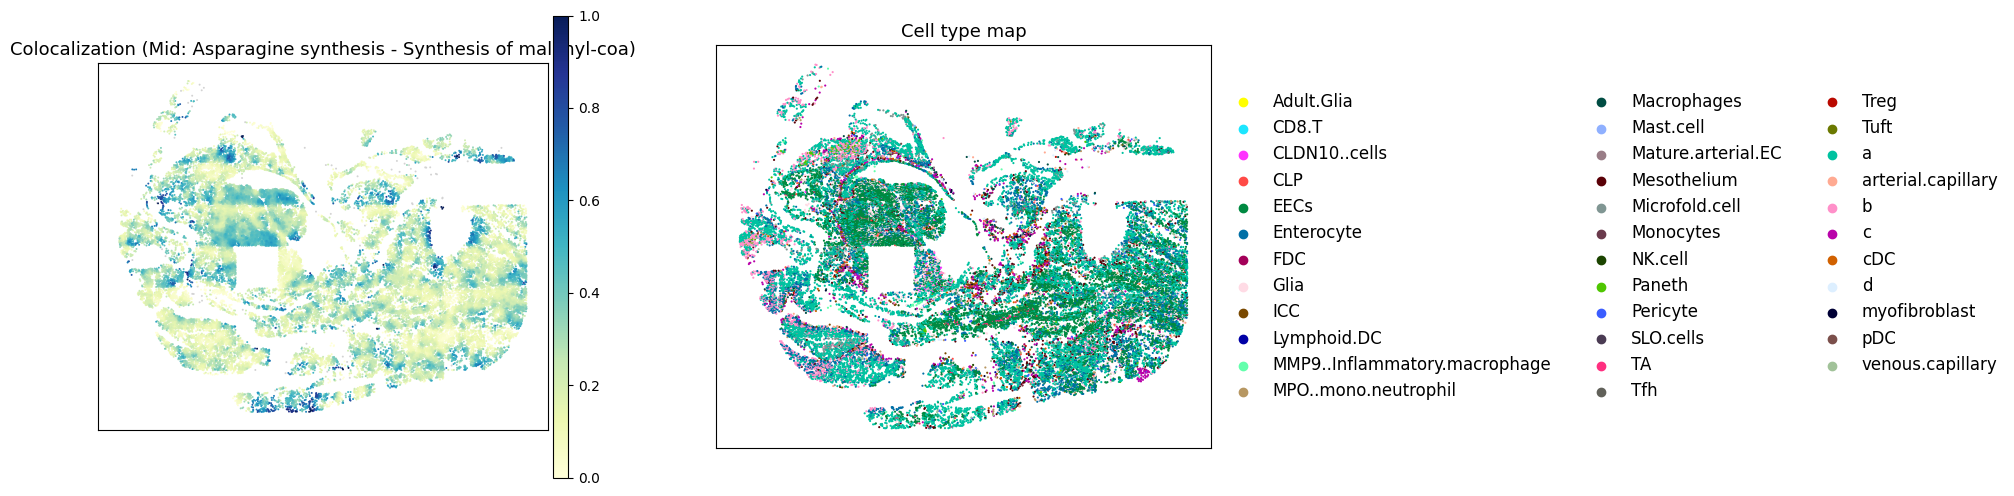

💾 Saved figure to: colocalization_pairs/Mid_colocalization_Asparagine synthesis_vs_Synthesis of malonyl-coa.png

🧬 Computing colocalization for Highest: Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism) - Synthesis of glucocerebroside ...
✅ Done computing colocalization for Highest: Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism) - Synthesis of glucocerebroside


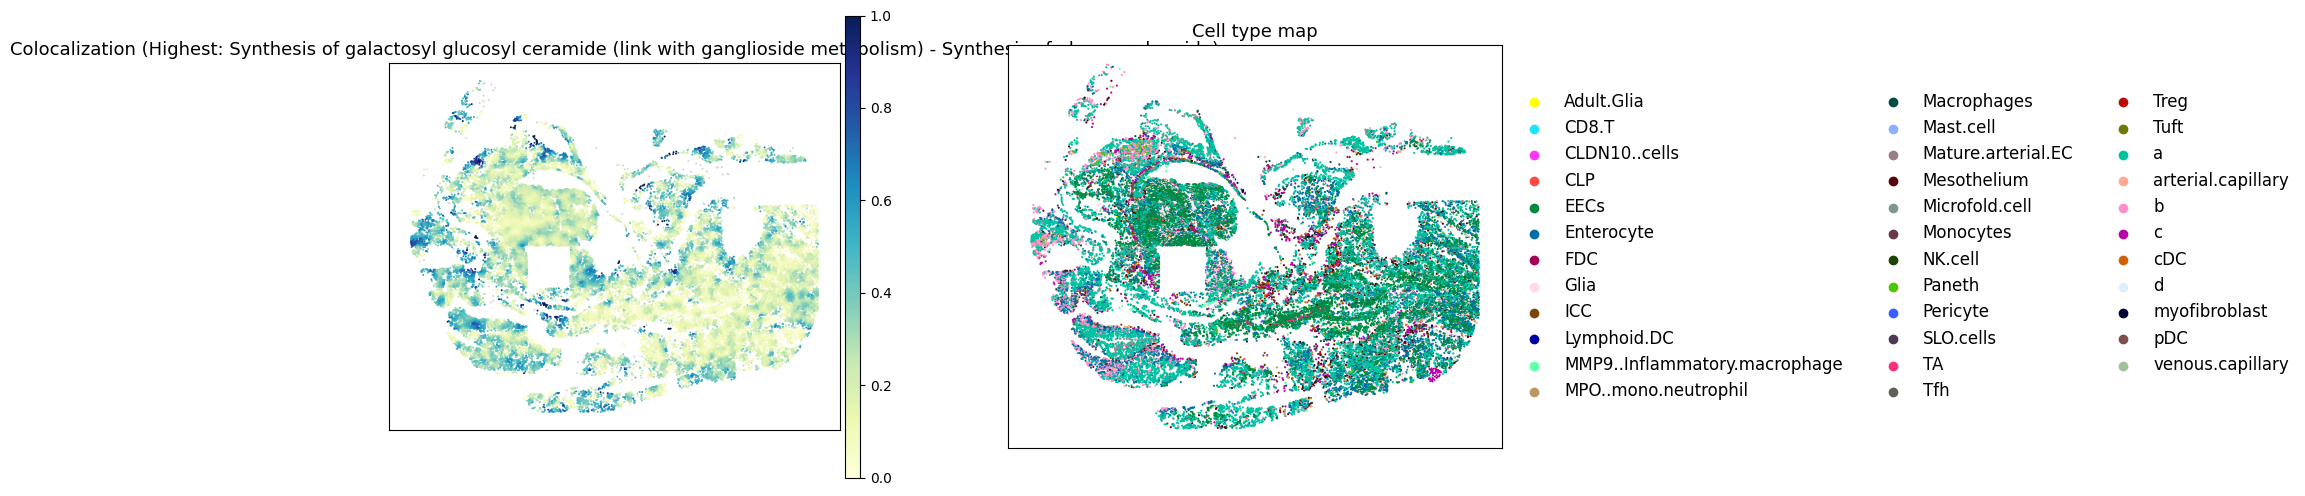

💾 Saved figure to: colocalization_pairs/Highest_colocalization_Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism)_vs_Synthesis of glucocerebroside.png

✅ All three colocalization maps generated and saved successfully.


In [53]:
# Folder to save results
os.makedirs("colocalization_pairs", exist_ok=True)

# Prepare the task pairs list
task_pairs = [
    ("Lowest", lowest.task_1, lowest.task_2),
    ("Mid", mid.task_1, mid.task_2),
    ("Highest", highest.task_1, highest.task_2)
]

# Loop over each pair
for level, task1, task2 in task_pairs:
    title = f"{level}: {task1} - {task2}"
    print(f"\n🧬 Computing colocalization for {title} ...")

    # Compute local colocalization score
    patient_adata_transfer.obs[title] = sccellfie.communication.compute_local_colocalization_scores(
        patient_adata_transfer,
        var1=task1,
        var2=task2,
        neighbors_radius=400,
        method='pairwise_concordance',
        min_neighbors=3,
        spatial_key='spatial',
        inplace=False
    )

    print(f"✅ Done computing colocalization for {title}")

    # ---- Plot colocalization (left) + cell type (right) ----
    keys = [title, 'cell_type']

    fig, axes = sccellfie.plotting.plot_spatial(
        patient_adata_transfer,
        keys=keys,
        cmap='YlGnBu',
        spot_size=200,
        use_raw=False,
        ncols=2,
        vmin=0,
        wspace=0.25,
        hspace=0.3
    )

    # Custom titles (above plots)
    axes[0].set_title(f"Colocalization ({title})", fontsize=13)
    axes[1].set_title("Cell type map", fontsize=13)

    # Layout adjustments
    fig.set_size_inches(14, 6)
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.25)

    # Show plot
    plt.show()

    # Save figure
    save_path = f"colocalization_pairs/{level}_colocalization_{task1}_vs_{task2}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved figure to: {save_path}")

print("\n✅ All three colocalization maps generated and saved successfully.")


In [54]:
patient_adata_transfer

AnnData object with n_obs × n_vars = 34549 × 81
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'Lowest: Cardiolipin synthesis - Conversion of glutamate to glutamine', 'Mid: Methionine degradation - Taurochenodeoxycholate synthesis', 'Highest: (R)-3-Hydroxybutanoate synthesis - Glutamate synthesis', 'Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion', 'Mid: Asparagine synthesis - Synthesis of malonyl-coa', 'Highest: Synthesis of galactosyl glucosyl c

In [ ]:
'cell_type', 'Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion', 'Mid: Asparagine synthesis - Synthesis of malonyl-coa', 'Highest: Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism) - Synthesis of glucocerebroside'

In [55]:
# Select the target columns
cols_of_interest = [
    'Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion',
    'Mid: Asparagine synthesis - Synthesis of malonyl-coa',
    'Highest: Synthesis of galactosyl glucosyl ceramide (link with ganglioside metabolism) - Synthesis of glucocerebroside'
]

# Create a DataFrame combining obs (cell metadata) and selected task columns
df = patient_adata_transfer.obs[["cell_type"] + cols_of_interest].copy()

# Group by cell type and calculate mean and standard deviation
grouped_mean = df.groupby("cell_type")[cols_of_interest].mean()
grouped_std = df.groupby("cell_type")[cols_of_interest].std()

# Combine results for clear display
summary = grouped_mean.round(3)
summary_std = grouped_std.round(3)

print("Mean activity per cell type:")
display(summary)

print("\nStandard deviation per cell type:")
display(summary_std)


Mean activity per cell type:


Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion  \
cell_type                                                                               
Adult.Glia                                                                 0.195        
CD8.T                                                                      0.209        
CLDN10..cells                                                              0.248        
CLP                                                                        0.226        
EECs                                                                       0.240        
Enterocyte                                                                 0.266        
FDC                                                                        0.134        
Glia                                                                       0.241        
ICC                                                                        0.192        
Lymphoid.DC                                                                0.177        
MMP9..Inflammatory.macrophage                                              0.204        
MPO..mono.neutrophil                                                       0.215        
Macrophages                                                                0.183        
Mast.cell                                                                  0.215        
Mature.arterial.EC                                                         0.168        
Mesothelium                                                                0.235        
Microfold.cell                                                             0.251        
Monocytes                                                                  0.173        
NK.cell                                                                    0.188        
Paneth                                                                     0.353        
Pericyte                                                                   0.215        
SLO.cells                                                                  0.219        
TA                                                                         0.282        
Tfh                                                                        0.293        
Treg                                                                       0.163        
Tuft                                                                       0.227        
a                                                                          0.269        
arterial.capillary                                                         0.217        
b                                                                          0.319        
c                                                                          0.198        
cDC                                                                        0.189        
d                                                                          0.142        
myofibroblast                                                              0.144        
pDC                                                                        0.207        
venous.capillary                                                           0.223        

                               Mid: Asparagine synthesis - Synthesis of malonyl-coa  \
cell_type                                                                             
Adult.Glia                                                                 0.164      
CD8.T                                                                      0.301      
CLDN10..cells                                                              0.234      
CLP                                                                        0.296      
EECs                                                                       0.283      
Enterocyte                                                                 0.253      
FDC                                      


Standard deviation per cell type:


Lowest: Synthesis of palmitoyl-CoA - Vesicle secretion  \
cell_type                                                                               
Adult.Glia                                                                 0.069        
CD8.T                                                                      0.074        
CLDN10..cells                                                              0.103        
CLP                                                                        0.102        
EECs                                                                       0.112        
Enterocyte                                                                 0.119        
FDC                                                                        0.057        
Glia                                                                       0.110        
ICC                                                                        0.091        
Lymphoid.DC                                                                0.088        
MMP9..Inflammatory.macrophage                                              0.103        
MPO..mono.neutrophil                                                       0.108        
Macrophages                                                                0.097        
Mast.cell                                                                  0.079        
Mature.arterial.EC                                                         0.108        
Mesothelium                                                                0.126        
Microfold.cell                                                             0.119        
Monocytes                                                                  0.045        
NK.cell                                                                    0.084        
Paneth                                                                     0.150        
Pericyte                                                                   0.109        
SLO.cells                                                                  0.033        
TA                                                                         0.102        
Tfh                                                                          NaN        
Treg                                                                       0.098        
Tuft                                                                       0.100        
a                                                                          0.135        
arterial.capillary                                                         0.114        
b                                                                          0.143        
c                                                                          0.110        
cDC                                                                        0.111        
d                                                                          0.071        
myofibroblast                                                              0.092        
pDC                                                                        0.158        
venous.capillary                                                           0.111        

                               Mid: Asparagine synthesis - Synthesis of malonyl-coa  \
cell_type                                                                             
Adult.Glia                                                                 0.072      
CD8.T                                                                      0.128      
CLDN10..cells                                                              0.149      
CLP                                                                        0.129      
EECs                                                                       0.130      
Enterocyte                                                                 0.137      
FDC                                      

<Figure size 1400x600 with 0 Axes>

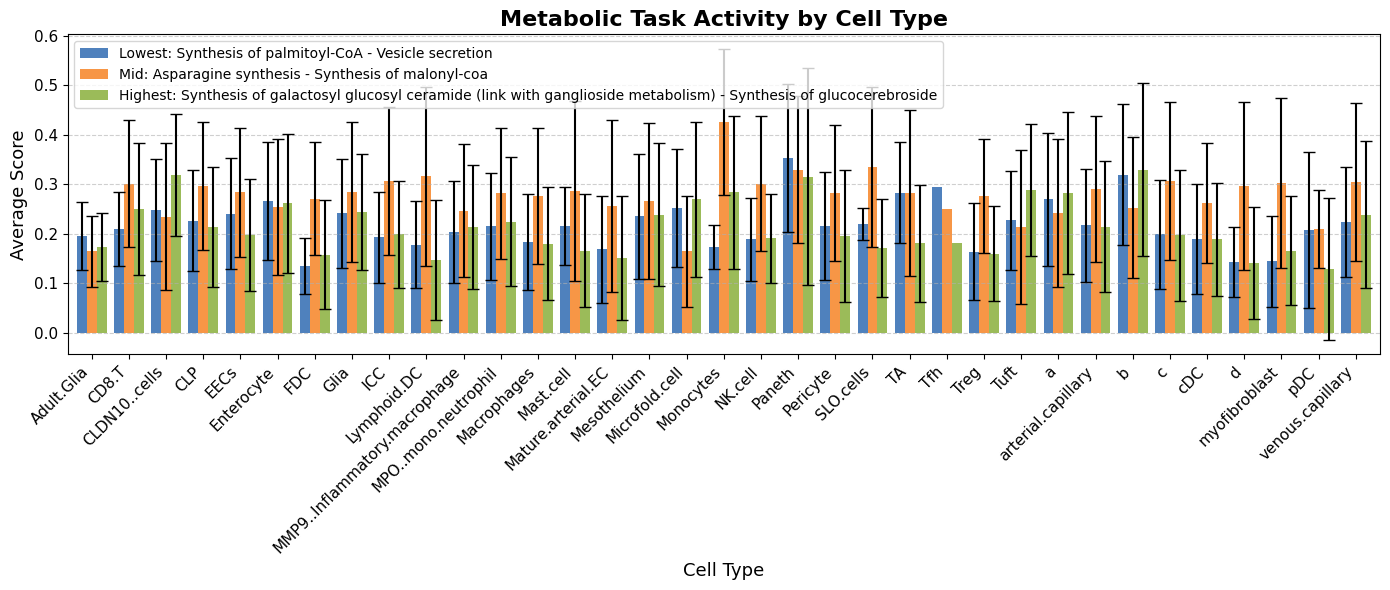

In [59]:
plt.figure(figsize=(14,6))  
summary.plot(
    kind='bar', 
    yerr=summary_std, 
    capsize=4, 
    figsize=(14,6),
    width=0.8,
    color=['#4F81BD', '#F79646', '#9BBB59']  
)

plt.title('Metabolic Task Activity by Cell Type', fontsize=16, fontweight='bold')
plt.ylabel('Average Score', fontsize=13)
plt.xlabel('Cell Type', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
# plt.legend(title='Metabolic Axis', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
